In [1]:
# This is a minimal set of modules to load 
import numpy as np
from skimage.measure import marching_cubes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from math import floor

In [2]:
# Set the string names of the files to load in 
higgs_name = "higgs_array_V4_scatteringxyz535h0.25args0.77-2.01.0"
x_name = "x_array_V4_scatteringxyz535h0.25args0.77-2.01.0"

In [3]:
# Load in the Higgs field and spatial array. 
hi = np.load(higgs_name)
x_vol = np.load(x_name)

# Extract relevant data from the x array
xmax = x_vol[-1][0][0][0]
ymax = x_vol[0][-1][0][1]
zmax = x_vol[0][0][-1][2]

px, py, pz = hi.shape
px -= 1
py -= 1
pz -= 1

h = x_vol[1][0][0][0] - x_vol[0][0][0][0]

In [4]:
# Use a 27-point stencil as defined in http://psych.colorado.edu/~oreilly/papers/OReillyBeckIP_lapl.pdf,
# with the h>=0.5 condition of Sutcliffe. 
vol = np.zeros((px-1, py-1, pz-1))
scale = 3.0/(13.0 * h**2)
for ix, iy, iz in product(range(px-1), range(py-1), range(pz-1)):
    if hi[ix+1][iy+1][iz+1] >= 0.5:
        continue
    vol[ix][iy][iz] = scale * ((-44.0/3.0)*hi[ix+1][iy+1][iz+1] + 
                        sum(hi[ix+jx+1][iy+jy+1][iz+jz+1]/(np.abs(jx)+np.abs(jy)+np.abs(jz))
                        for jx, jy, jz in product(range(-1, 2), repeat=3) if any((jx, jy, jz))))

# Set parameters for how much one can inset (which ignores outer energy density values which may be
# more affected by numerical instability).
max_insets = [floor(si/2 - 1) for si in vol.shape]
print("maximum insets:", max_insets)

maximum insets: [18, 10, 18]


In [5]:
# vol thus stores the energy density of the monopole on a region slightly less than x_vol
# To avoid spurious observations at the boundary, we trim the dataset by an amount 'inset'
# at each edge. One could probably set inset=1, but as we are not pressed here I take 3. 

insets = [5, 3, 5]
if any(inset>max_inset for inset, max_inset in zip(insets, max_insets)):
    print("Inset Error")

insetx, insety, insetz = insets
vol_trimmed = vol[insetx: -insetx, insety: -insety, insetz: -insetz]

In [6]:
# Here we create a dynamic plot for finding a good iso_val, using a slider.
# https://scikit-image.org/docs/dev/api/skimage.measure.html#marching-cubes
%matplotlib inline

def plot_func(iso_val):
    verts, faces, _, _ = marching_cubes(vol_trimmed, iso_val, spacing=(h, h, h))
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    plt.setp(ax.get_zticklabels(), visible=False)
    ax.set_xlim3d([0, 2*(xmax-h*(1+insetx))])
    ax.set_ylim3d([0, 2*(ymax-h*(1+insety))])
    ax.set_zlim3d([0, 2*(zmax-h*(1+insetz))])
    ax.set_box_aspect(aspect = ((xmax-h*(1+insetx)), (ymax-h*(1+insety)), (zmax-h*(1+insetz))))
    ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], lw=1, cmap='cool')
    ax.view_init(elev=30., azim=-60.)
    plt.show()

interact(plot_func, iso_val=widgets.FloatSlider(value=0.22, min=0.0, max=0.5, step=0.01))

interactive(children=(FloatSlider(value=0.22, description='iso_val', max=0.5, step=0.01), Output()), _dom_clas…

<function __main__.plot_func(iso_val)>

<IPython.core.display.Javascript object>


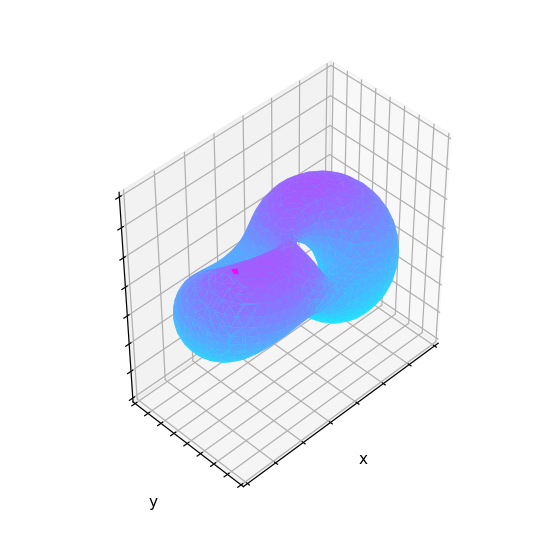

In [7]:
# Here we set a specific iso_val, and the can have a plot we can rotate in 3 space. 
%matplotlib notebook 

iso_val = 0.18

verts, faces, _, _ = marching_cubes(vol_trimmed, iso_val, spacing=(h, h, h))
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
plt.setp( ax.get_xticklabels(), visible=False)
plt.setp( ax.get_yticklabels(), visible=False)
plt.setp( ax.get_zticklabels(), visible=False)
plt.xlabel("x")
plt.ylabel("y")
ax.set_xlim3d([0, 2*(xmax-h*(1+insetx))])
ax.set_ylim3d([0, 2*(ymax-h*(1+insety))])
ax.set_zlim3d([0, 2*(zmax-h*(1+insetz))])
ax.set_box_aspect(aspect = ((xmax-h*(1+insetx)), (ymax-h*(1+insety)), (zmax-h*(1+insetz))))
ax.view_init(elev=30., azim=-60.)
ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], lw=1, cmap='cool')

In [8]:
# One can save tge figure as desired. 
# print(higgs_name)
# plt.savefig("paper_data/plots/V4_scatteringxyz535h0.25args0.450.21.0_{}.png".format(iso_val), 
#             bbox_inches='tight')